In [4]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../../")

In [5]:
import time
import random
import warnings
from multiprocessing import cpu_count
from itertools import chain
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import joblib
import ray

from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from processing.utils import CleanUp, SNOWBALL_STEMMER, RSLP_STEMMER

%matplotlib inline

clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)

corpus = []

In [9]:
ray.shutdown()
ray.init(num_cpus=cpu_count(), include_webui=False, lru_evict=True)

filename = f"{os.getcwd()}/../../../data/embedding/corpus.txt"
file_it = pd.read_csv(filename, header=None, iterator=True, names=["sentence"], chunksize=1000,)

@ray.remote
def carregar_frases(lines):
    import os
    import sys

    sys.path.append(f"{os.getcwd()}/../../")
    from processing.utils import CleanUp, SNOWBALL_STEMMER
    clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)
    
    lines = lines["sentence"].tolist()
    return [clean_up.fit(line) for line in lines]

itera = []
i = 0
for lines in file_it:
    itera.append(lines)
    if i == 2:
        break
    i += 1
corpus = list(chain(*ray.get([carregar_frases.remote(lines) for lines in itera])))

ray.shutdown()

2020-06-05 00:54:46,246	INFO resource_spec.py:204 -- Starting Ray with 4.74 GiB memory available for workers and up to 2.39 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [10]:
# len(corpus)
clean_up.fit("meu deus eu to com falta de ar??????")

'meu deus estou com nao consig respir duv'

In [11]:
df = pd.read_csv(f"{os.getcwd()}/../../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [12]:
print(random.choice(textos))
print(len(textos))

for item in list(textos[:, 0]):
    corpus.append(item)
# corpus += textos[:, 0]
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['revis mental tud que fiz sext feir uma mae que receb beb ate enta estav assintomat fez febr log segu tav com dor gargant vei covid posit agor nao sei que sint psicossomat estou mesm sent parano covid'
 0]
2321


In [13]:
# class Word2VecVectorizer(TransformerMixin, BaseEstimator):
    
#     def __init__(self):
#         self.w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")
#         # print(f"Palavras no vocab: {len(list(self.w2v.wv.vocab))}")
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         n_textos = []
#         for texto in X:
#             doc = []
#             for palavra in texto.split():
#                 try:
#                     doc.append(self.w2v.wv[palavra])
#                 except:
#                     doc.append(np.zeros(300, ))
#             n_textos.append(np.mean(doc, axis=0))
#         return StandardScaler().fit_transform(np.asarray(n_textos)) 
    
#     def fit_transform(self, X, y=None):
#         return self.transform(X)

In [14]:
# w2v = Word2VecVectorizer()
# sgd_w2v = SGDClassifier(
#     alpha=1e-7,
#     random_state=0,
#     n_jobs=-1,
#     max_iter=3000,
#     n_iter_no_change=50
# )

# pipe = make_pipeline(w2v, sgd_w2v)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# pipe.fit(X_train, y_train)
# pred = pipe.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [25]:
validacoes, N = [], 6
for ngram_range in zip(np.ones((N), dtype=np.int), range(1, N)):
    acc, f1 = [], []
    tfidf = TfidfVectorizer(ngram_range=ngram_range, lowercase=False).fit(corpus)
    for _ in range(5):
        clf = SVC(kernel="linear", C=7)
        pipe = make_pipeline(tfidf, clf)

        X = textos[:, 0]
        y = textos[:, 1].astype(np.int).ravel()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        acc.append(round(accuracy_score(pred, y_test) * 100, 2))
        f1.append(round(f1_score(pred, y_test) * 100, 2))

    validacoes.append((
        ngram_range,
        round(np.mean(acc), 2),
        np.max(acc),
        round(np.mean(f1), 2),
        np.max(f1)
    ))

In [26]:
columns = ["NGram", "Accuracy", "Acc Max.", "F1", "F1 Max."]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1 Max.", "Acc Max.", "NGram"], ascending=False)
ngram_range = df.reset_index().loc[0]["NGram"]
df.head(25)

,NGram,Accuracy,Acc Max.,F1,F1 Max.
2,"(1, 3)",74.97,77.85,72.14,74.57
4,"(1, 5)",73.50,76.13,71.63,74.24
1,"(1, 2)",75.18,76.56,70.41,73.04
3,"(1, 4)",74.92,76.13,71.67,73.02
0,"(1, 1)",72.64,75.48,67.41,72.60


## Modelo final selecionado

In [15]:
print(f"NGram escolhido: {ngram_range}")
tfidf = TfidfVectorizer(ngram_range=ngram_range, lowercase=False).fit(corpus)

NGram escolhido: (1, 3)


In [16]:
# parameters = {
#     'kernel': ('linear', 'rbf'), 
#     'gamma': [0.1, 0.5, 1, 2], 
#     'C': [0.1, 0.5, 1, 5, 7, 15],
#     'random_state': [0, 10, 100, 1000]
# }

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X = tfidf.transform(X)

# svc = SVC()
# clf = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
# clf.fit(X, y)

In [17]:
# result = []
# for param, score in zip(clf.cv_results_['params'], clf.cv_results_['split0_test_score']):
#     result.append((score, param))
# sorted(result, key=lambda x: x[0], reverse=True)

Cross Validation accuracy: 0.74 (+/- 0.03)

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       276
           1       0.70      0.80      0.75       189

    accuracy                           0.78       465
   macro avg       0.77      0.78      0.77       465
weighted avg       0.79      0.78      0.78       465



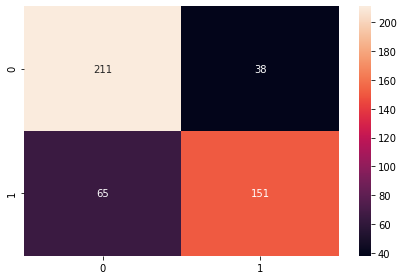

In [18]:
clf = SVC(kernel="linear", C=5, random_state=0)

pipe = make_pipeline(tfidf, clf)

X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe.fit(X_train, y_train)

scores = cross_val_score(pipe, X_train, y_train, cv=5)
print("Cross Validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()

pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

In [19]:
# params = {
#     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'alpha': [1e-1, 1e-3, 1e-5, 1e-7],
#     'max_iter': [500, 1000, 2000, 3000],
#     'n_iter_no_change': [10, 25, 50]
# }

# clf = make_pipeline(tfidf, 
#                     GridSearchCV(SGDClassifier(random_state=0, n_jobs=-1,),
#                                  params,
#                                  cv=5,
#                                  refit=True, n_jobs=-1))

# params = {
#     'kernel': ['linear', 'rbf', 'sigmoid'],
#     'C': [0.1, 0.5, 1, 5, 10],
#     'tol': [1e-1, 1e-2, 1e-3, 1e-4],
#     'decision_function_shape': ['ovo', 'ovr']
# }

# cv = GridSearchCV(SVC(random_state=0), params, refit=True, n_jobs=-1)
# clf = make_pipeline(tfidf, cv)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [20]:
# clf1 = make_pipeline(w2v, sgd_w2v)
# clf2 = make_pipeline(tfidf, sgd_tfidf)

# eclf = VotingClassifier(
#     estimators=[('w2v', clf1), ('tfidf', clf2)],
#     voting='hard', weights=[1, 1], n_jobs=-1
# )

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# eclf.fit(X_train, y_train)
# pred = eclf.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [22]:
clf = SVC(kernel="linear", C=5, random_state=0)
pipe = make_pipeline(tfidf, clf)

X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

pipe.fit(X, y)

joblib.dump(pipe, f"{os.getcwd()}/../../ai/models/tweets_classifier.model")

['/ssd/programas/Covid19-Twitter-Tracker/code/src/notebook/validacoes/../../ai/models/tweets_classifier.model']